# NOTEBOOK RdN 
___

Análisis estadístico

### Importamos librerías

In [1]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## TASA DE CONVERSIÓN HISTÓRICA POR EQUIPO

### Conectamos con SQL

Ejecutamos Query sobre base de datos

In [ ]:
# Establecer la conexión a la base de datos
conn = mysql.connector.connect(
    host='xx.x.xx.xxx', 
    port=xxxx,     
    user='xxxxxxxxxx',      
    password='xxxxxxxxxx', 
    database='xxxxx' 
)

In [3]:
cursor = conn.cursor()

# Escribe tu consulta SQL
# query = "SELECT DATE(v.recordedAt) AS fecha, v.equipmentId AS Equipo, COUNT(*) AS Registros FROM Videos v WHERE v.deleted = 0 AND v.toDelete = 0 GROUP BY DATE(v.recordedAt) , v.equipmentId;"
query = """SELECT 
                e.equipmentId,
                ROUND(100 * COUNT(IF(i.discarded = 0,
                            i.infractionId,
                            NULL)) / COUNT(DISTINCT IF(processedAt IS NOT NULL,
                                v.videoId,
                                NULL)),
                        1) AS TasaConversionHistorica
            FROM
                Videos v
                    LEFT JOIN
                Infractions i ON v.videoId = i.videoId
                    JOIN
                Equipments e ON v.equipmentId = e.equipmentId
            WHERE
                DATE(v.recordedAt) >= '2023-10-01'
                
                # FILTROS SELECTIVOS --------------
                    # AND e.municipalityId = 1
                    # AND v.externalprovider = 1
                    # AND e.equipmentId = 117
                # ---------------------------------
                
            GROUP BY e.equipmentId; """ 

# Ejecuta la consulta
cursor.execute(query)

# Obtén todos los resultados de la consulta
resultados = cursor.fetchall()


In [4]:
# Obtén los nombres de las columnas
columnas = [col[0] for col in cursor.description]

# Convierte los resultados a un DataFrame
df = pd.DataFrame(resultados, columns=columnas)

In [5]:
# Cierra el cursor y la conexión a MySQL
cursor.close()
conn.close()
print("Conexión a MySQL cerrada")

Conexión a MySQL cerrada


### Dataframe 

In [6]:
df_tasaConversionH = df.copy()

In [7]:
df_tasaConversionH

,equipmentId,TasaConversionHistorica
0,1,4.9
1,2,2.5
2,3,4.5
3,4,5.4
4,5,6.5
...,...,...
71,542,2.4
72,543,0.2
73,544,0.3
74,545,0.9


# Análisis estadístico y tasas de conversión
___

Planteamos Query y realizamos análsis

In [8]:
query = """SELECT 
    YEAR(v.recordedAt) as Año,
    MONTH(v.recordedAt) as Mes,
    v.externalProvider as ID_IA,
    v.equipmentId, 
    COUNT(DISTINCT v.videoId) as Registados, 
    COUNT(DISTINCT CASE WHEN v.externalProvider = 0 THEN v.videoId ELSE NULL END) as NoIA,
    COUNT(DISTINCT CASE WHEN v.externalProvider != 0 THEN v.videoId ELSE NULL END) as SiIA, 
    COUNT(DISTINCT CASE WHEN v.externalProvider != 0 and v.allegedInfraction = 0 THEN v.videoId ELSE NULL END) as NoAprIA, 
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 THEN v.videoId ELSE NULL END) as SiAprIA,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NULL THEN v.videoId ELSE NULL END) as NoEditor,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NOT NULL THEN v.videoId ELSE NULL END) as SiEditor,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NOT NULL AND v.approved = 0 THEN v.videoId ELSE NULL END) as NoAprEditor,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NOT NULL AND v.approved = 1 THEN v.videoId ELSE NULL END) as SiAprEditor,
    COUNT(DISTINCT CASE WHEN i.discarded=1 THEN i.videoId ELSE NULL END) as NoImputable,
    COUNT(DISTINCT CASE WHEN i.discarded=0 THEN i.videoId ELSE NULL END) as SiImputable, 
    COUNT(DISTINCT CASE WHEN i.discarded=0 and i.transfered = 0 THEN i.videoId ELSE NULL END) as NoTransfer,
    COUNT(DISTINCT CASE WHEN i.discarded=0 and i.transfered = 1 THEN i.videoId ELSE NULL END) as SiTransfer,
    COUNT(DISTINCT CASE WHEN t.procesado_SPI is null THEN t.transferId ELSE NULL END) as NoProcSPI,
    COUNT(DISTINCT CASE WHEN t.procesado_SPI=1 THEN t.transferId ELSE NULL END) as SiProcSPI,
    COUNT(DISTINCT CASE WHEN t.procesado_SPI=1 and t.discardReason_SPI is not null THEN t.transferId ELSE NULL END) as NoAprSPI,
    COUNT(DISTINCT CASE WHEN t.procesado_SPI=1 and t.aprobado_SPI = 1 THEN t.transferId ELSE NULL END) as SiAprSPI,
    COUNT(DISTINCT CASE WHEN t.procesado_SPI=1 and t.aprobado_SPI = 0 and t.discardReason_SPI is null THEN t.transferId ELSE NULL END) as EsperaSPI
FROM
    Videos v
LEFT JOIN
    Infractions i ON v.videoId = i.videoId
left join Transfers t on i.transferId=t.transferId    
WHERE
    v.recordedAt >= '2023-10-01'
    AND NOT (v.externalProvider = 0 AND v.deleted = 1)
GROUP BY Año, Mes, ID_IA, equipmentId;"""

In [9]:
# Establecer la conexión a la base de datos
conn = mysql.connector.connect(
    host='10.0.50.104', 
    port=3306,     
    user='lroldan',      
    password='13579!!', 
    database='tng' 
)

cursor = conn.cursor()
# Ejecuta la consulta
cursor.execute(query)

# Obtén todos los resultados de la consulta
resultados = cursor.fetchall()

# Obtén los nombres de las columnas
columnas = [col[0] for col in cursor.description]

# Convierte los resultados a un DataFrame
df = pd.DataFrame(resultados, columns=columnas)

# Cierra el cursor y la conexión a MySQL
cursor.close()
conn.close()
print("Conexión a MySQL cerrada")

Conexión a MySQL cerrada


In [10]:
df

,Año,Mes,ID_IA,equipmentId,Registados,NoIA,SiIA,NoAprIA,SiAprIA,NoEditor,...,SiAprEditor,NoImputable,SiImputable,NoTransfer,SiTransfer,NoProcSPI,SiProcSPI,NoAprSPI,SiAprSPI,EsperaSPI
0,2023,10,1,4,8241,0,8241,7489,752,0,...,717,290,427,0,427,0,427,25,402,0
1,2023,10,1,17,2957,0,2957,2717,240,0,...,105,70,35,0,35,0,35,2,33,0
2,2023,10,1,102,1000,0,1000,945,55,0,...,50,11,39,0,39,0,39,2,37,0
3,2023,10,1,109,11200,0,11200,11135,65,0,...,51,17,34,0,34,0,34,0,34,0
4,2023,10,1,111,1000,0,1000,859,141,0,...,55,35,20,0,20,0,20,1,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2024,5,1,305,1096,0,1096,1036,60,9,...,48,14,34,34,0,0,0,0,0,0
794,2024,5,2,401,405,0,405,405,0,0,...,0,0,0,0,0,0,0,0,0,0
795,2024,5,2,405,2479,0,2479,2479,0,0,...,0,0,0,0,0,0,0,0,0,0
796,2024,5,2,408,1669,0,1669,1669,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculamos tasas de conversión por período

In [24]:
# Agrupar por 'Año', 'Mes' y 'equipmentId' y calcular la suma de las columnas 'Registados', 'NoIA', 'SiIA', 'NoAprIA', 'SiAprIA'
df_grouped_IA = df.groupby(['Año', 'Mes', 'equipmentId']).agg({
    'Registados': 'sum',
    'NoIA': 'sum',
    'SiIA': 'sum',
    'NoAprIA': 'sum',
    'SiAprIA': 'sum'
}).reset_index()

# Calcular la Tasa_IA
df_grouped_IA['Tasa_IA'] = (df_grouped_IA['SiAprIA'] / df_grouped_IA['SiIA']) * 100

df_grouped_IA


,Año,Mes,equipmentId,Registados,NoIA,SiIA,NoAprIA,SiAprIA,Tasa_IA
0,2023,10,1,5826,0,5826,4437,1389,23.841401
1,2023,10,2,9518,0,9518,8276,1242,13.048960
2,2023,10,3,18522,0,18522,16585,1937,10.457834
3,2023,10,4,12182,0,12182,10996,1186,9.735676
4,2023,10,5,7777,0,7777,6237,1540,19.801980
...,...,...,...,...,...,...,...,...,...
563,2024,5,541,2439,2439,0,0,0,NaN
564,2024,5,542,2446,2446,0,0,0,NaN
565,2024,5,545,1802,1802,0,0,0,NaN
566,2024,5,546,2190,2190,0,0,0,NaN


### Evolución de la tasa por mes x Equipo

In [26]:
df_equipment_401 = df_grouped_IA[df_grouped_IA['equipmentId'] == 401]

df_equipment_401

,Año,Mes,equipmentId,Registados,NoIA,SiIA,NoAprIA,SiAprIA,Tasa_IA
57,2023,10,401,9230,0,9230,9190,40,0.433369
129,2023,11,401,5082,0,5082,5052,30,0.590319
200,2023,12,401,4753,0,4753,4725,28,0.589102
273,2024,1,401,4080,0,4080,4071,9,0.220588
343,2024,2,401,6359,0,6359,6354,5,0.078629
416,2024,3,401,5135,0,5135,5133,2,0.038948
488,2024,4,401,6559,0,6559,6547,12,0.182955
554,2024,5,401,4078,3673,405,405,0,0.000000


## REGISTROS POR MES

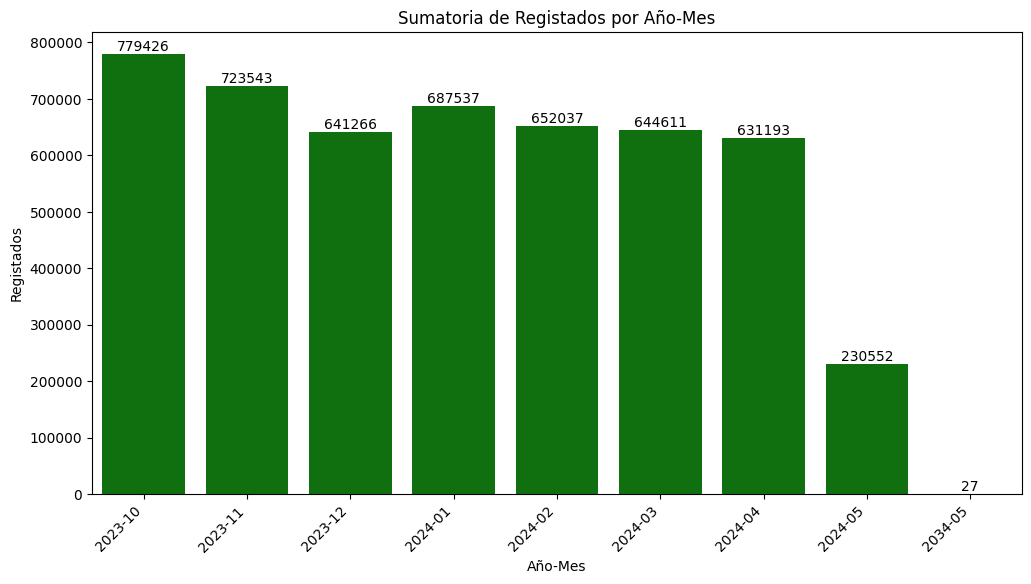

In [13]:
# Agrupar por 'Año' y 'Mes' y calcular la suma de la columna 'Registados'
df_grouped = df.groupby(['Año', 'Mes']).sum()['Registados']

# Convertir el MultiIndex a un DataFrame normal
df_grouped = df_grouped.reset_index()

# Crear una nueva columna 'Año-Mes' concatenando 'Año' y 'Mes' como cadena
df_grouped['Año-Mes'] = df_grouped.apply(lambda x: f"{x['Año']}-{x['Mes']:02d}", axis=1)

# Crear un gráfico de barras verticales utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Año-Mes', y='Registados', data=df_grouped, color='g')

# Obtener los valores de 'Registados' para cada barra
valores = df_grouped['Registados']

# Añadir etiquetas de valores a cada barra
for i in range(len(valores)):
    plt.text(x=i, y=valores[i] + 0.5, s=str(valores[i]), ha='center', va='bottom')

# Añadir etiquetas a los ejes
plt.xlabel('Año-Mes')
plt.ylabel('Registados')

# Añadir un título al gráfico
plt.title('Sumatoria de Registados por Año-Mes')

# Rotar las etiquetas del eje x para que sean legibles
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()




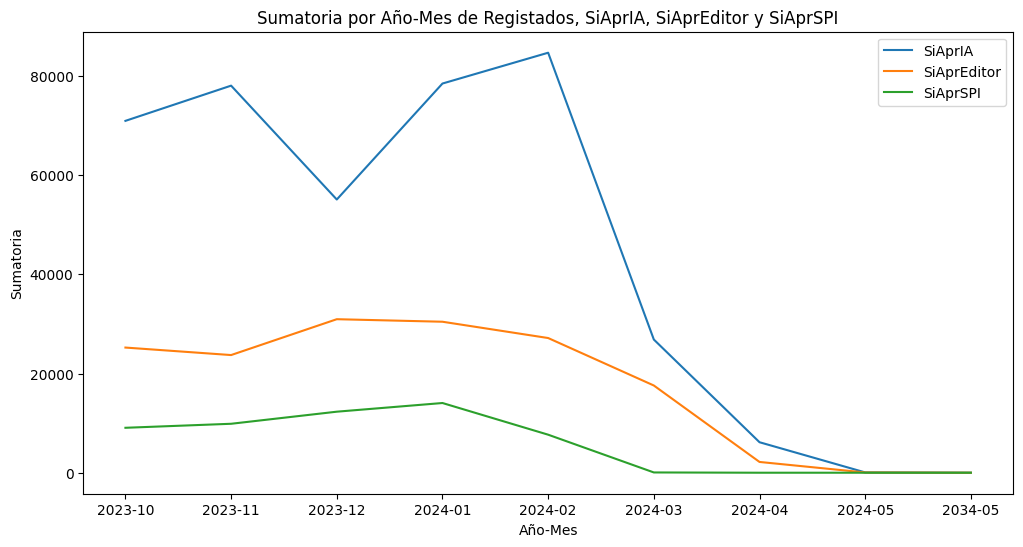

In [14]:
# Agrupar por 'Año' y 'Mes' y calcular la suma de las columnas deseadas
df_grouped = df.groupby(['Año', 'Mes']).sum()[['Registados', 'SiAprIA', 'SiAprEditor', 'SiAprSPI']]

# Crear una nueva columna 'Año-Mes' concatenando 'Año' y 'Mes' como cadena
df_grouped['Año-Mes'] = df_grouped.index.to_flat_index().map(lambda x: f"{x[0]}-{x[1]:02d}")

# Mover 'Año-Mes' como el índice
df_grouped.set_index('Año-Mes', inplace=True)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Lista de columnas a trazar
columnas = ['SiAprIA', 'SiAprEditor', 'SiAprSPI']

# Graficar cada columna
for columna in columnas:
    plt.plot(df_grouped.index, df_grouped[columna], label=columna)

# Añadir etiquetas a los ejes
plt.xlabel('Año-Mes')
plt.ylabel('Sumatoria')

# Añadir un título al gráfico
plt.title('Sumatoria por Año-Mes de Registados, SiAprIA, SiAprEditor y SiAprSPI')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


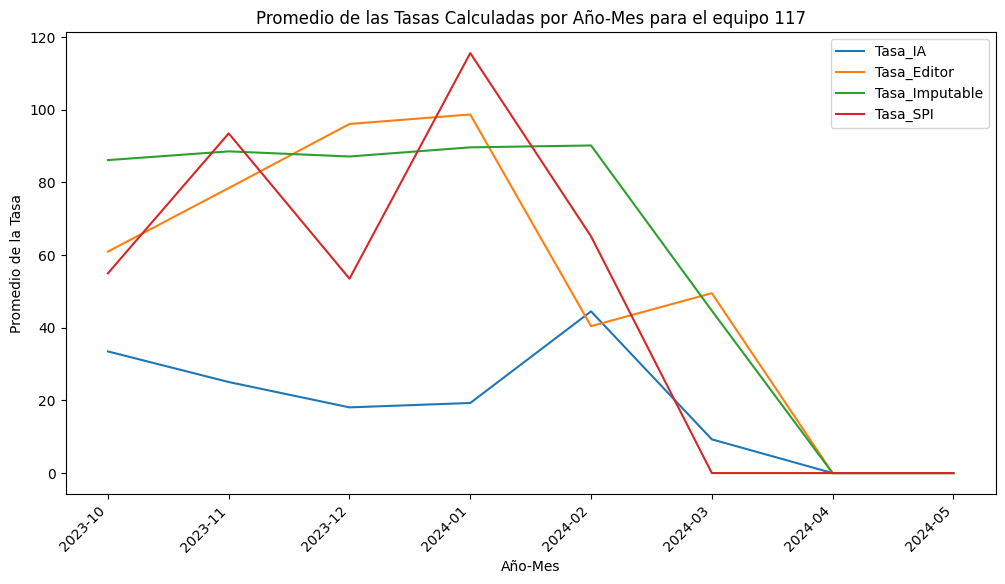

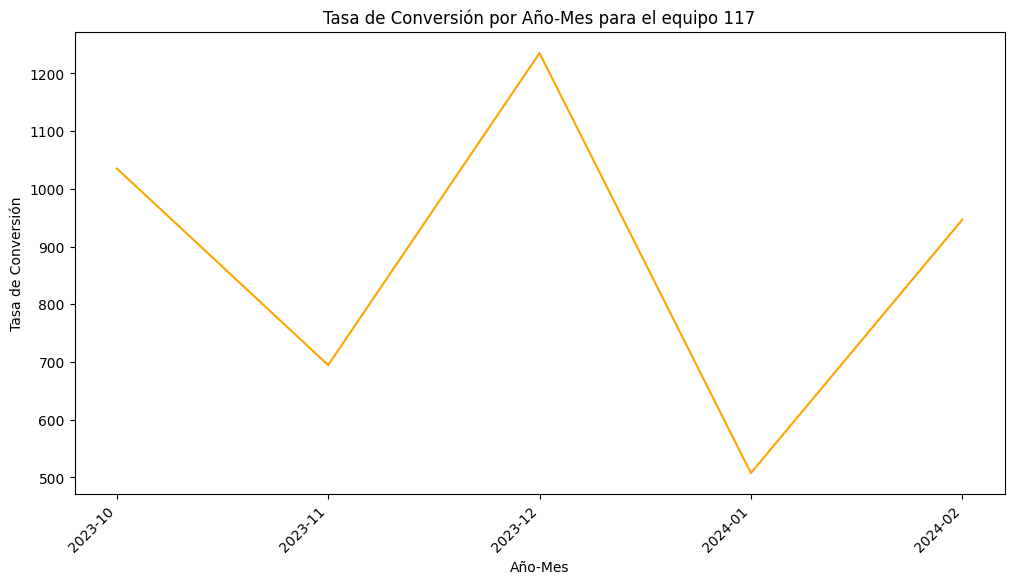

In [15]:
# Filtrar los datos para el equipo 117
df_equipo_117 = df[df['equipmentId'] == 117]

# Agrupar por 'Año-Mes' y calcular el promedio de las tasas (excepto 'Tasa_Conversion')
df_grouped = df_equipo_117.groupby(['Año', 'Mes']).agg({
    'Tasa_IA': 'mean',
    'Tasa_Editor': 'mean',
    'Tasa_Imputable': 'mean',
    'Tasa_SPI': 'mean'
}).reset_index()

# Crear una nueva columna 'Año-Mes' concatenando 'Año' y 'Mes'
# Convertir 'Año' y 'Mes' a enteros antes de formatearlos
df_grouped['Año-Mes'] = df_grouped.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)


# Visualizar el promedio de las tasas calculadas (excepto 'Tasa_Conversion')
plt.figure(figsize=(12, 6))
for column in ['Tasa_IA', 'Tasa_Editor', 'Tasa_Imputable', 'Tasa_SPI']:
    sns.lineplot(x='Año-Mes', y=column, data=df_grouped, label=column)

# Configuración del gráfico
plt.xlabel('Año-Mes')
plt.ylabel('Promedio de la Tasa')
plt.title('Promedio de las Tasas Calculadas por Año-Mes para el equipo 117')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Calcular el promedio de la tasa de conversión
df_conversion = df_equipo_117.groupby(['Año', 'Mes']).agg({'Tasa_Conversion': 'mean'}).reset_index()

# Crear una nueva columna 'Año-Mes' concatenando 'Año' y 'Mes'
# Convertir 'Año' y 'Mes' a enteros antes de aplicar el formato
df_conversion['Año-Mes'] = df_conversion.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)


# Visualizar la tasa de conversión en un gráfico separado
plt.figure(figsize=(12, 6))
sns.lineplot(x='Año-Mes', y='Tasa_Conversion', data=df_conversion, color='orange')

# Configuración del gráfico
plt.xlabel('Año-Mes')
plt.ylabel('Tasa de Conversión')
plt.title('Tasa de Conversión por Año-Mes para el equipo 117')
plt.xticks(rotation=45, ha='right')
plt.show()


C:\Users\leabr\AppData\Local\Temp\ipykernel_14592\2020413591.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_10.index, y='Relacion_SiAprSPI_Registados', data=bottom_10, palette='coolwarm',


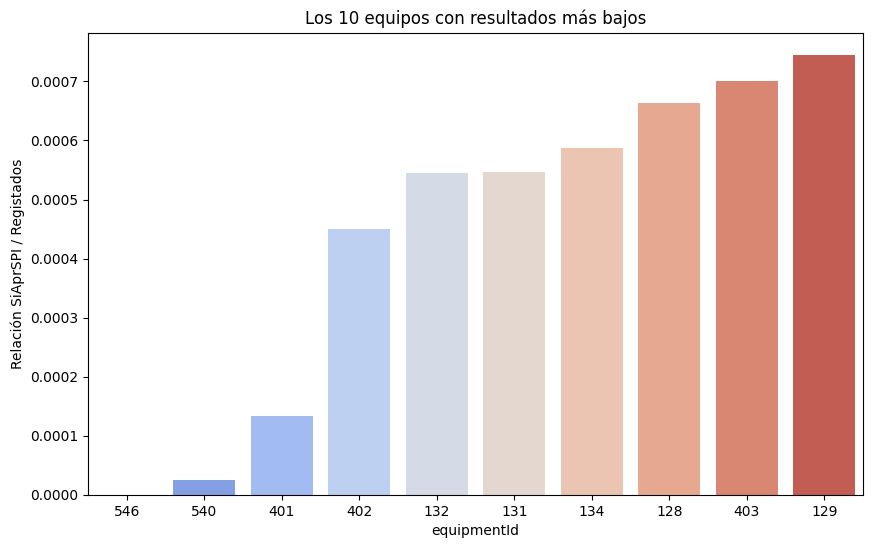

C:\Users\leabr\AppData\Local\Temp\ipykernel_14592\2020413591.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.index, y='Relacion_SiAprSPI_Registados', data=top_10, palette='coolwarm',


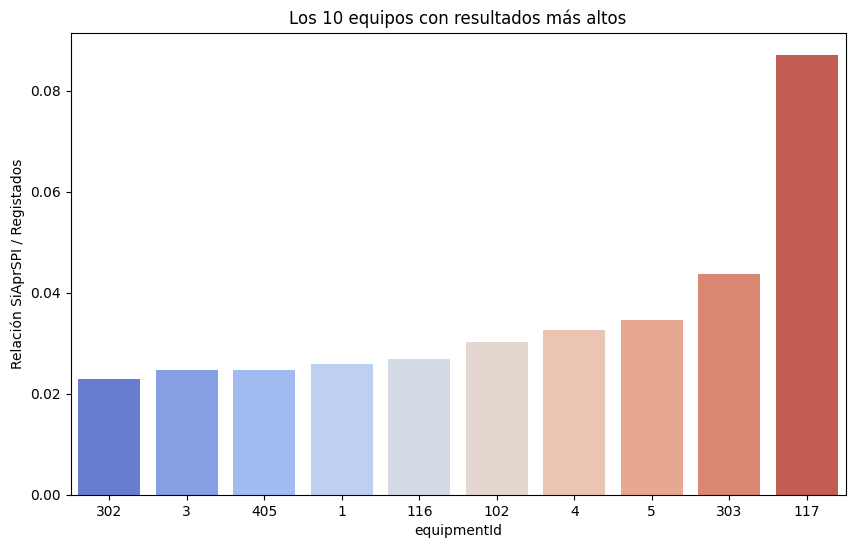

In [16]:
# Agrupar los datos por 'equipmentId' y calcular la sumatoria de 'Registados' y 'SiAprSPI'
grouped_df = df.groupby('equipmentId').agg({
    'Registados': 'sum',
    'SiAprSPI': 'sum'
})

# Calcular la relación entre 'SiAprSPI' y 'Registados' para cada 'equipmentId'
grouped_df['Relacion_SiAprSPI_Registados'] = grouped_df['SiAprSPI'] / grouped_df['Registados']

# Ordenar los datos por la relación calculada
grouped_df_sorted = grouped_df.sort_values(by='Relacion_SiAprSPI_Registados')

# Extraer los 10 equipos con los resultados más bajos
bottom_10 = grouped_df_sorted.head(10)

# Extraer los 10 equipos con los resultados más altos
top_10 = grouped_df_sorted.tail(10)

# Gráfico de barras para los 10 equipos con los resultados más bajos
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_10.index, y='Relacion_SiAprSPI_Registados', data=bottom_10, palette='coolwarm',
            order=bottom_10.index)  # Ordena las barras según el orden de los datos

plt.xlabel('equipmentId')
plt.ylabel('Relación SiAprSPI / Registados')
plt.title('Los 10 equipos con resultados más bajos')
plt.show()

# Gráfico de barras para los 10 equipos con los resultados más altos
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.index, y='Relacion_SiAprSPI_Registados', data=top_10, palette='coolwarm',
            order=top_10.index)  # Ordena las barras según el orden de los datos

plt.xlabel('equipmentId')
plt.ylabel('Relación SiAprSPI / Registados')
plt.title('Los 10 equipos con resultados más altos')
plt.show()

In [17]:
# Filtrar los registros según la condición dada
filtered_df = df[(df['NoIA'] == 0) &
                 (df['NoEditor'] == 0) &
                 (df['SiEditor'] > 0) &
                 (df['SiEditor'] == df['SiAprIA'])]

# Calcular la columna 'Tasa_Conver_Impu'
filtered_df['Tasa_Conver_Impu'] = (filtered_df['SiImputable'] / filtered_df['Registados']) * 100

# Mostrar los primeros registros del DataFrame filtrado y con la nueva columna
print(filtered_df.head())


    Año  Mes  ID_IA  equipmentId  Registados  NoIA   SiIA  NoAprIA  SiAprIA  \
0  2023   10      1            4        8241     0   8241     7489      752   
1  2023   10      1           17        2957     0   2957     2717      240   
2  2023   10      1          102        1000     0   1000      945       55   
3  2023   10      1          109       11200     0  11200    11135       65   
4  2023   10      1          111        1000     0   1000      859      141   

   NoEditor  ...  SiProcSPI  NoAprSPI  SiAprSPI  EsperaSPI    Tasa_IA  \
0         0  ...        427        25       402          0   9.125106   
1         0  ...         35         2        33          0   8.116334   
2         0  ...         39         2        37          0   5.500000   
3         0  ...         34         0        34          0   0.580357   
4         0  ...         20         1        19          0  14.100000   

   Tasa_Editor  Tasa_Imputable    Tasa_SPI  Tasa_Conversion  Tasa_Conver_Impu  
0    9

C:\Users\leabr\AppData\Local\Temp\ipykernel_14592\1829896368.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tasa_Conver_Impu'] = (filtered_df['SiImputable'] / filtered_df['Registados']) * 100


In [18]:
filtered_df

,Año,Mes,ID_IA,equipmentId,Registados,NoIA,SiIA,NoAprIA,SiAprIA,NoEditor,...,SiProcSPI,NoAprSPI,SiAprSPI,EsperaSPI,Tasa_IA,Tasa_Editor,Tasa_Imputable,Tasa_SPI,Tasa_Conversion,Tasa_Conver_Impu
0,2023,10,1,4,8241,0,8241,7489,752,0,...,427,25,402,0,9.125106,95.345745,59.553696,94.145199,2.050000e+03,5.181410
1,2023,10,1,17,2957,0,2957,2717,240,0,...,35,2,33,0,8.116334,43.750000,33.333333,94.285714,8.960606e+03,1.183632
2,2023,10,1,102,1000,0,1000,945,55,0,...,39,2,37,0,5.500000,90.909091,78.000000,94.871795,2.702703e+03,3.900000
3,2023,10,1,109,11200,0,11200,11135,65,0,...,34,0,34,0,0.580357,78.461538,66.666667,100.000000,3.294118e+04,0.303571
4,2023,10,1,111,1000,0,1000,859,141,0,...,20,1,19,0,14.100000,39.007092,36.363636,95.000000,5.263158e+03,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,2024,4,2,133,4000,0,4000,3989,11,0,...,0,0,0,0,0.275000,100.000000,63.636364,0.000000,inf,0.175000
705,2024,4,2,134,2022,0,2022,1995,27,0,...,0,0,0,0,1.335312,100.000000,25.925926,0.000000,inf,0.346192
708,2024,4,2,304,4000,0,4000,3890,110,0,...,0,0,0,0,2.750000,65.454545,43.055556,0.000000,inf,0.775000
711,2024,4,2,309,1483,0,1483,1417,66,0,...,0,0,0,0,4.450438,87.878788,63.793103,0.000000,inf,2.494943


In [19]:
filtered_df.to_excel('filtered_df.xlsx', index=False)

PermissionError: [Errno 13] Permission denied: 'filtered_df.xlsx'

In [ ]:
# Agrupar por 'Año' y 'Mes' y calcular la tasa de imputabilidad
grouped_df = filtered_df.groupby(['Año', 'Mes']).agg(
    SiImputable_sum=('SiImputable', 'sum'),
    Registrados_sum=('Registados', 'sum')
).reset_index()

grouped_df['tasa_impu'] = (grouped_df['SiImputable_sum'] / grouped_df['Registrados_sum']) * 100

# Mostrar el DataFrame agrupado con la tasa de imputabilidad
print(grouped_df)


    Año  Mes  SiImputable_sum  Registrados_sum  tasa_impu
0  2023   10             9990           594833   1.679463
1  2023   11             7704           461233   1.670305
2  2023   12             8965           455816   1.966802
3  2024    1            14365           613098   2.343019
4  2024    2            13047           503481   2.591359
5  2024    3             4924           282732   1.741579
6  2024    4              170            19012   0.894172


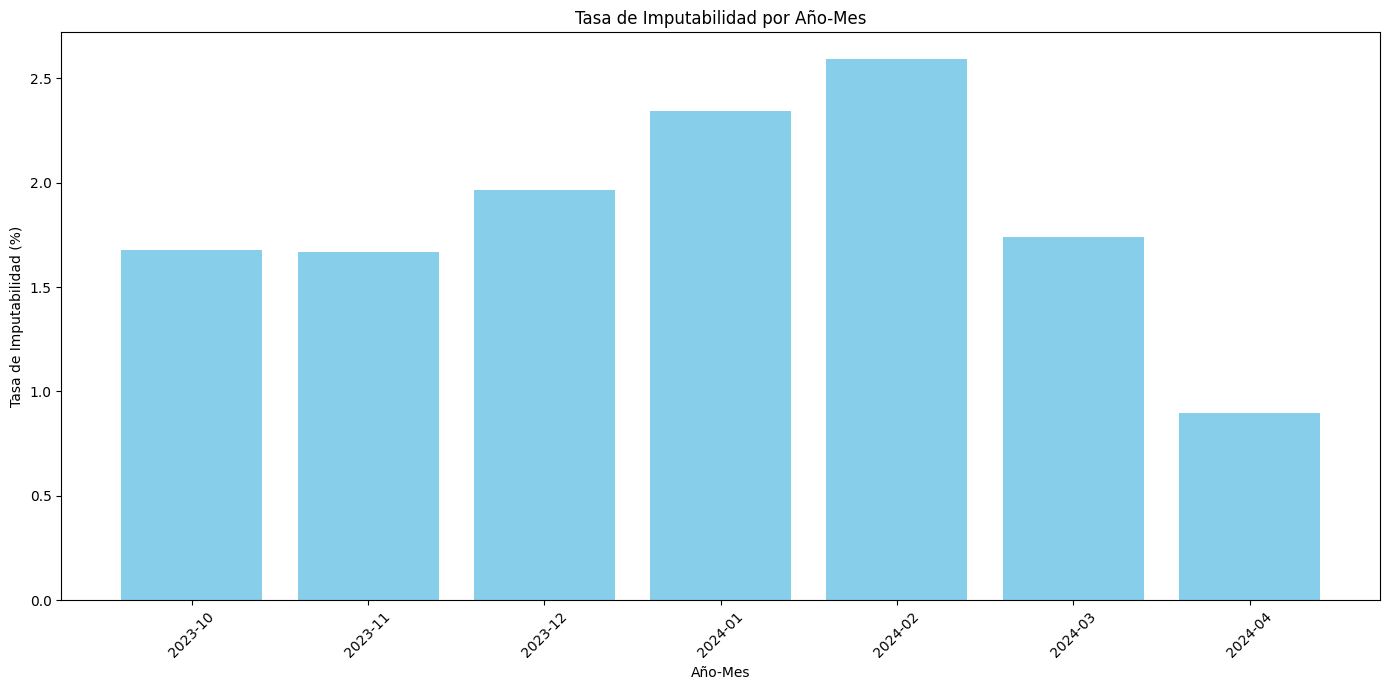

In [ ]:
# Asegurarse de que las columnas 'Año' y 'Mes' sean de tipo entero
grouped_df['Año'] = grouped_df['Año'].astype(int)
grouped_df['Mes'] = grouped_df['Mes'].astype(int)

# Crear una columna 'Año-Mes' para el gráfico
grouped_df['Año-Mes'] = grouped_df.apply(lambda x: f"{x['Año']}-{int(x['Mes']):02d}", axis=1)

# Ordenar los datos por 'tasa_impu' para la gráfica
grouped_df = grouped_df.sort_values(by='Año-Mes')

# Gráfico de barras
plt.figure(figsize=(14, 7))
plt.bar(grouped_df['Año-Mes'], grouped_df['tasa_impu'], color='skyblue')
plt.xlabel('Año-Mes')
plt.ylabel('Tasa de Imputabilidad (%)')
plt.title('Tasa de Imputabilidad por Año-Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\leabr\AppData\Local\Temp\ipykernel_2660\3091992266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tasa_Conver_Impu'] = (filtered_df['SiImputable'] / filtered_df['Registados']) * 100


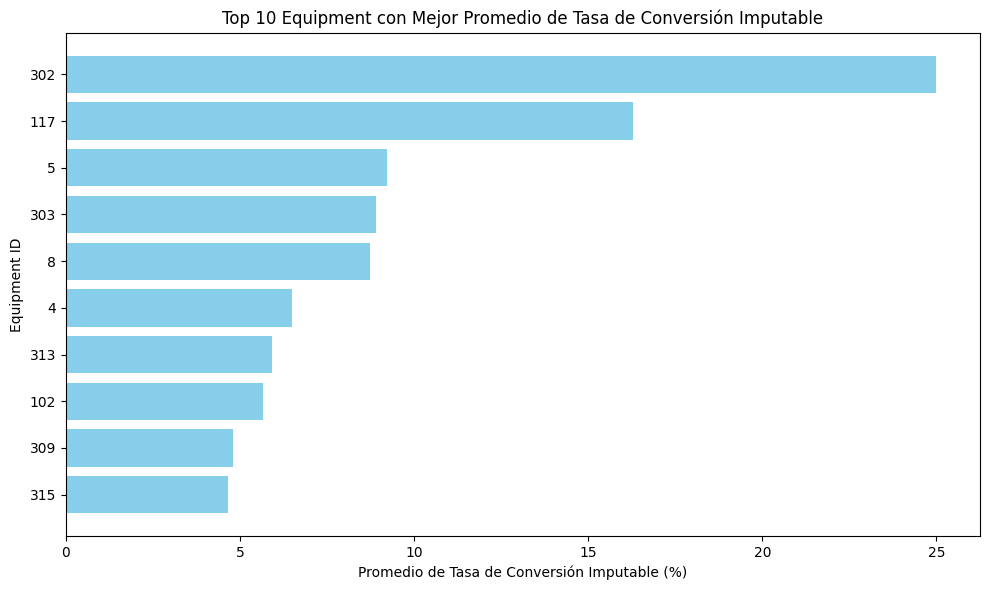

In [ ]:
# Calcular 'Tasa_Conver_Impu' en filtered_df
filtered_df['Tasa_Conver_Impu'] = (filtered_df['SiImputable'] / filtered_df['Registados']) * 100

# Agrupar por 'equipmentId' y calcular el promedio de 'Tasa_Conver_Impu'
grouped_equipment = filtered_df.groupby('equipmentId').agg(
    Tasa_Conver_Impu_mean=('Tasa_Conver_Impu', 'mean')
).reset_index()

# Seleccionar los diez equipos con los mejores promedios de 'Tasa_Conver_Impu'
top_10_equipment = grouped_equipment.nlargest(10, 'Tasa_Conver_Impu_mean')

# Convertir 'equipmentId' a string
top_10_equipment['equipmentId'] = top_10_equipment['equipmentId'].astype(str)

# Ordenar los resultados por 'Tasa_Conver_Impu_mean' para la gráfica
top_10_equipment = top_10_equipment.sort_values(by='Tasa_Conver_Impu_mean', ascending=True)

# Crear un gráfico de barras lateral
plt.figure(figsize=(10, 6))
plt.barh(top_10_equipment['equipmentId'], top_10_equipment['Tasa_Conver_Impu_mean'], color='skyblue')
plt.xlabel('Promedio de Tasa de Conversión Imputable (%)')
plt.ylabel('Equipment ID')
plt.title('Top 10 Equipment con Mejor Promedio de Tasa de Conversión Imputable')
plt.tight_layout()
plt.show()


C:\Users\leabr\AppData\Local\Temp\ipykernel_2660\1784883674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Año-Mes'] = filtered_df.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)


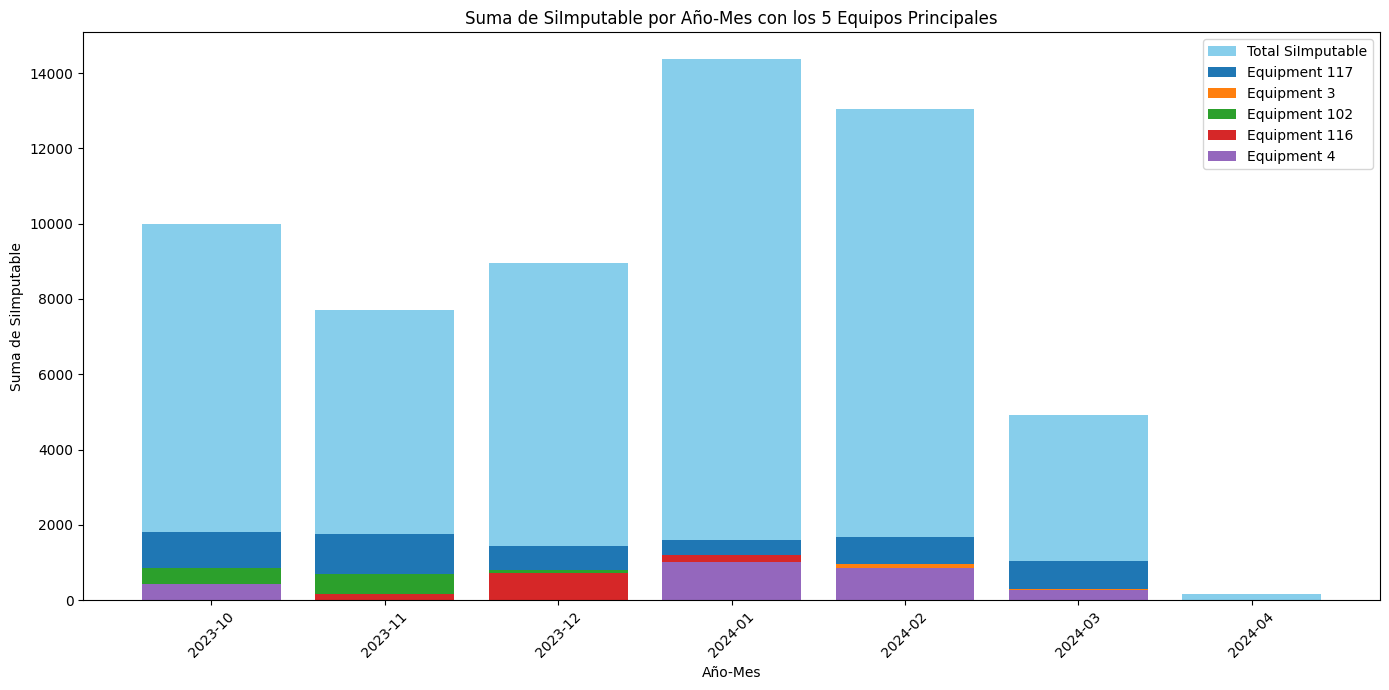

In [ ]:
# Crear una columna 'Año-Mes'
filtered_df['Año-Mes'] = filtered_df.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)

# Agrupar por 'Año-Mes' y sumar 'SiImputable'
grouped_by_month = filtered_df.groupby('Año-Mes').agg(SiImputable_sum=('SiImputable', 'sum')).reset_index()

# Identificar los 5 equipmentId con mayor suma de 'SiImputable'
top_5_equipment = filtered_df.groupby('equipmentId').agg(SiImputable_sum=('SiImputable', 'sum')).nlargest(5, 'SiImputable_sum').reset_index()

# Graficar la suma de SiImputable por Año-Mes
plt.figure(figsize=(14, 7))

# Crear un gráfico de barras para la suma de SiImputable por Año-Mes
plt.bar(grouped_by_month['Año-Mes'], grouped_by_month['SiImputable_sum'], color='skyblue', label='Total SiImputable')

# Añadir las barras para los 5 equipos con mayor suma de SiImputable
for equipment_id in top_5_equipment['equipmentId']:
    filtered_by_equipment = filtered_df[filtered_df['equipmentId'] == equipment_id]
    monthly_sum_by_equipment = filtered_by_equipment.groupby('Año-Mes').agg(SiImputable_sum=('SiImputable', 'sum')).reset_index()
    plt.bar(monthly_sum_by_equipment['Año-Mes'], monthly_sum_by_equipment['SiImputable_sum'], label=f'Equipment {equipment_id}')

# Configurar etiquetas y título del gráfico
plt.xlabel('Año-Mes')
plt.ylabel('Suma de SiImputable')
plt.title('Suma de SiImputable por Año-Mes con los 5 Equipos Principales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


C:\Users\leabr\AppData\Local\Temp\ipykernel_2660\600504968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Año-Mes'] = filtered_df.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)


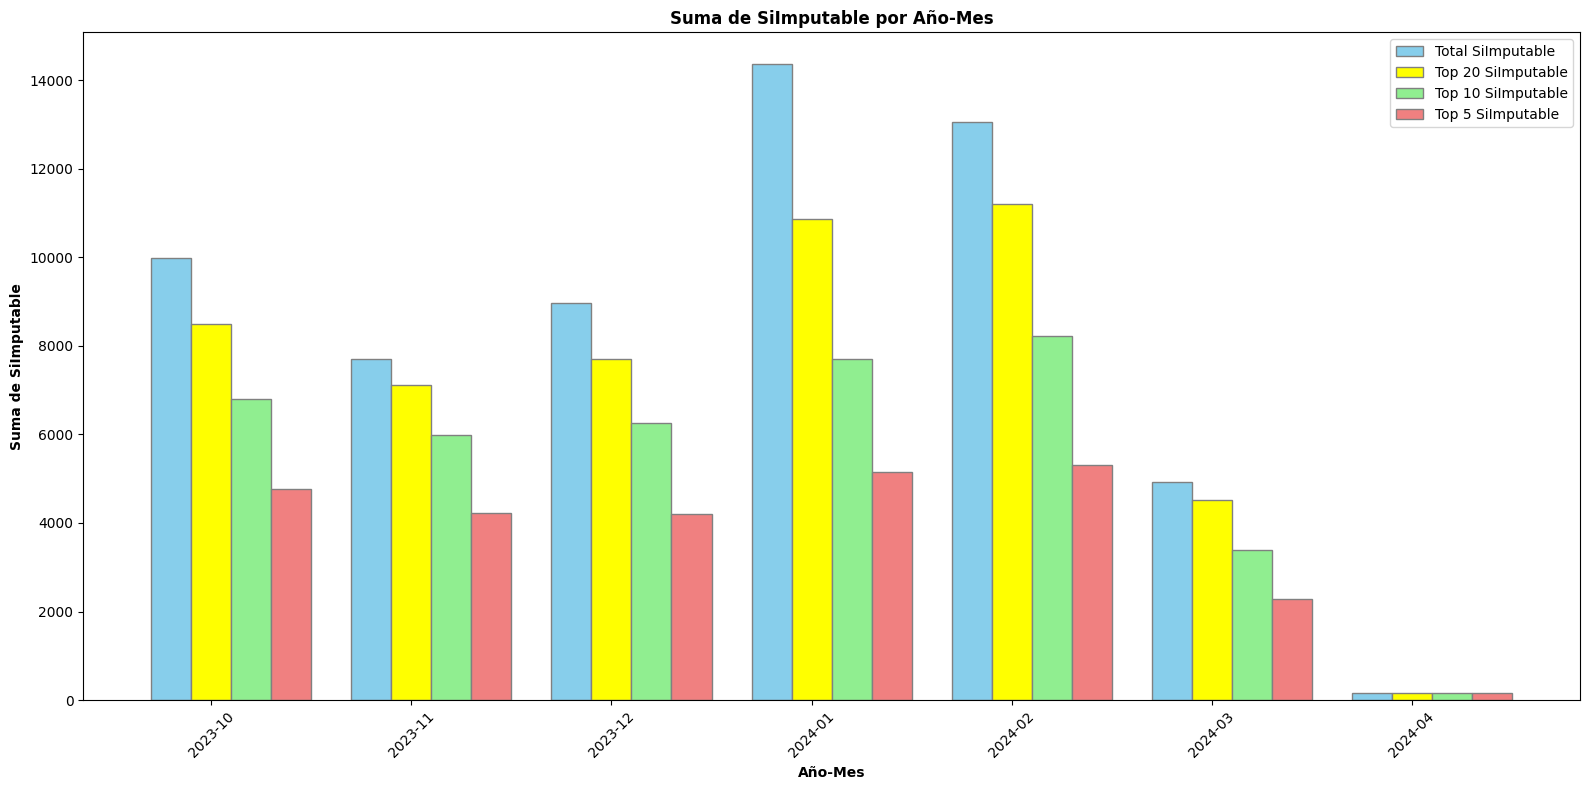

In [ ]:
# Crear una columna 'Año-Mes'
filtered_df['Año-Mes'] = filtered_df.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)

# Agrupar por 'Año-Mes' y sumar 'SiImputable'
total_siimputable_by_month = filtered_df.groupby('Año-Mes').agg(Total_SiImputable=('SiImputable', 'sum')).reset_index()

# Calcular la suma de SiImputable de los 5 principales equipmentId para cada periodo
top_5_siimputable_by_month = filtered_df.groupby(['Año-Mes', 'equipmentId']).agg(SiImputable_sum=('SiImputable', 'sum')).reset_index()

# Filtrar los 5 principales equipmentId para cada 'Año-Mes'
top_5_per_month = top_5_siimputable_by_month.groupby('Año-Mes').apply(lambda x: x.nlargest(5, 'SiImputable_sum')).reset_index(drop=True)

# Sumar los SiImputable de los 5 principales equipmentId para cada periodo
top_5_sum_by_month = top_5_per_month.groupby('Año-Mes').agg(Top5_SiImputable=('SiImputable_sum', 'sum')).reset_index()

# Filtrar los 10 principales equipmentId para cada 'Año-Mes'
top_10_per_month = top_5_siimputable_by_month.groupby('Año-Mes').apply(lambda x: x.nlargest(10, 'SiImputable_sum')).reset_index(drop=True)

# Sumar los SiImputable de los 10 principales equipmentId para cada periodo
top_10_sum_by_month = top_10_per_month.groupby('Año-Mes').agg(Top10_SiImputable=('SiImputable_sum', 'sum')).reset_index()

# Filtrar los 20 principales equipmentId para cada 'Año-Mes'
top_20_per_month = top_5_siimputable_by_month.groupby('Año-Mes').apply(lambda x: x.nlargest(20, 'SiImputable_sum')).reset_index(drop=True)

# Sumar los SiImputable de los 20 principales equipmentId para cada periodo
top_20_sum_by_month = top_20_per_month.groupby('Año-Mes').agg(Top20_SiImputable=('SiImputable_sum', 'sum')).reset_index()

# Combinar ambos resultados en un solo DataFrame
combined_df = pd.merge(total_siimputable_by_month, top_5_sum_by_month, on='Año-Mes')
combined_df = pd.merge(combined_df, top_10_sum_by_month, on='Año-Mes')
combined_df = pd.merge(combined_df, top_20_sum_by_month, on='Año-Mes')

# Configurar el gráfico
plt.figure(figsize=(16, 8))

# Definir el ancho de las barras y las posiciones
bar_width = 0.20
r1 = range(len(combined_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Crear las barras para Total SiImputable
plt.bar(r1, combined_df['Total_SiImputable'], color='skyblue', width=bar_width, edgecolor='grey', label='Total SiImputable')

# Crear las barras para Top 20 SiImputable
plt.bar(r2, combined_df['Top20_SiImputable'], color='yellow', width=bar_width, edgecolor='grey', label='Top 20 SiImputable')

# Crear las barras para Top 10 SiImputable
plt.bar(r3, combined_df['Top10_SiImputable'], color='lightgreen', width=bar_width, edgecolor='grey', label='Top 10 SiImputable')

# Crear las barras para Top 5 SiImputable
plt.bar(r4, combined_df['Top5_SiImputable'], color='lightcoral', width=bar_width, edgecolor='grey', label='Top 5 SiImputable')

# Añadir etiquetas y título
plt.xlabel('Año-Mes', fontweight='bold')
plt.ylabel('Suma de SiImputable', fontweight='bold')
plt.title('Suma de SiImputable por Año-Mes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(combined_df))], combined_df['Año-Mes'], rotation=45)

# Añadir leyenda
plt.legend()

# Ajustar el layout para evitar recortes en las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()


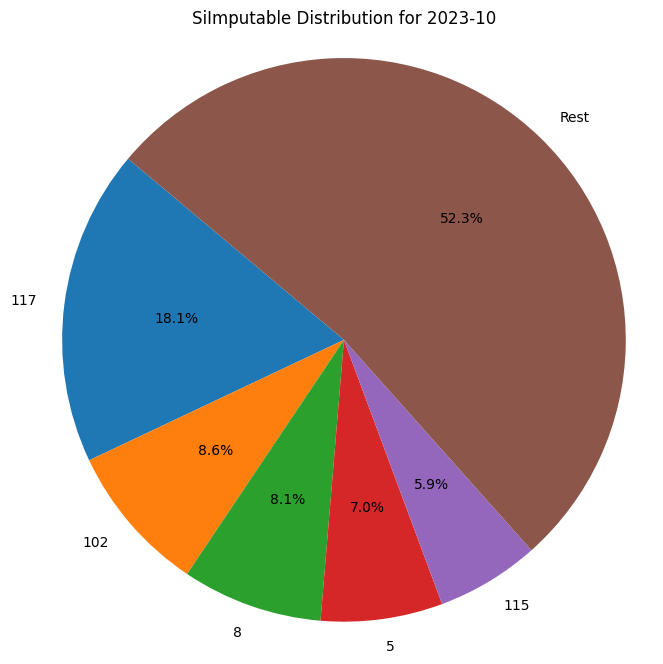

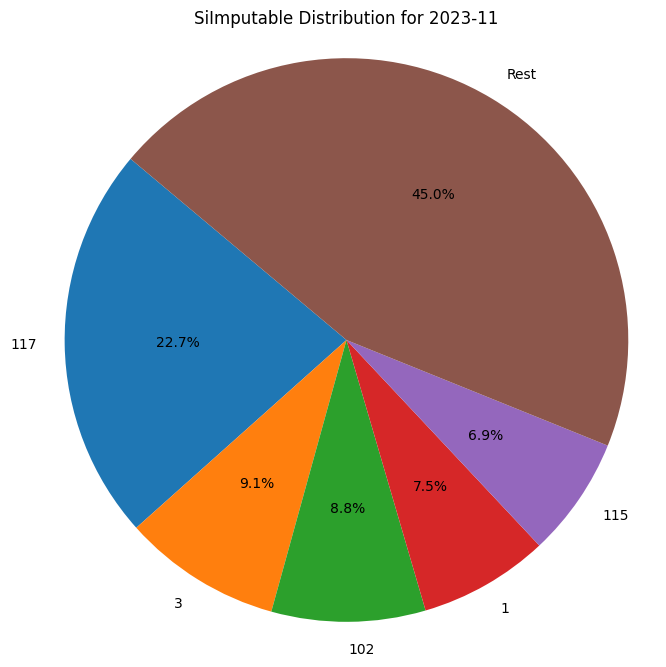

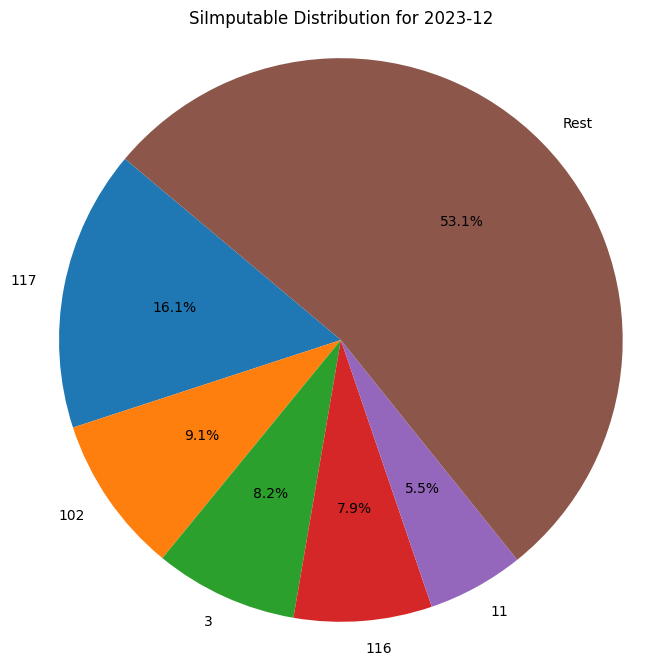

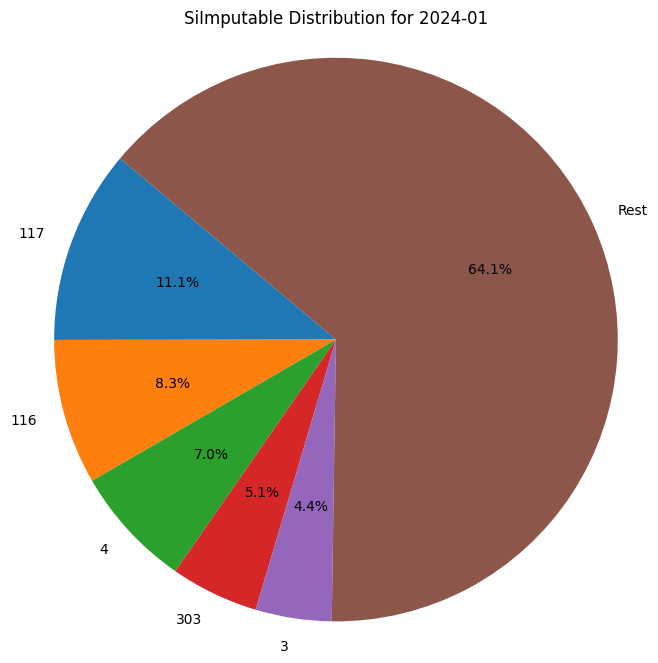

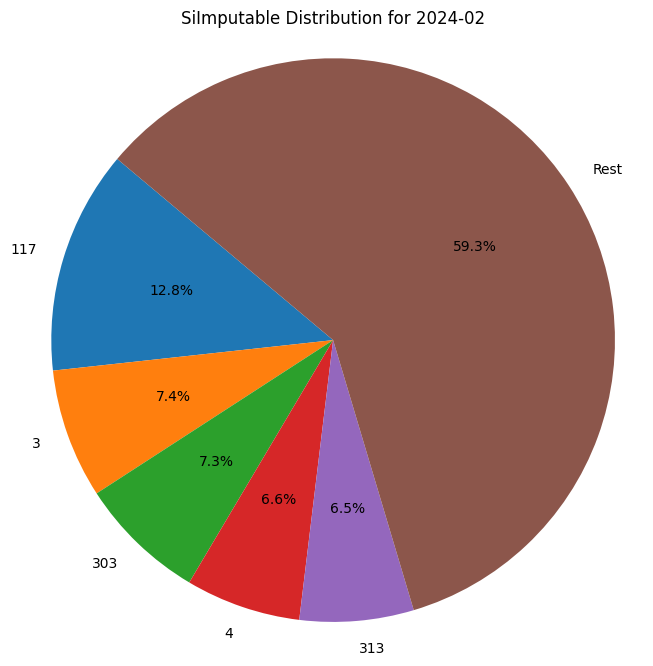

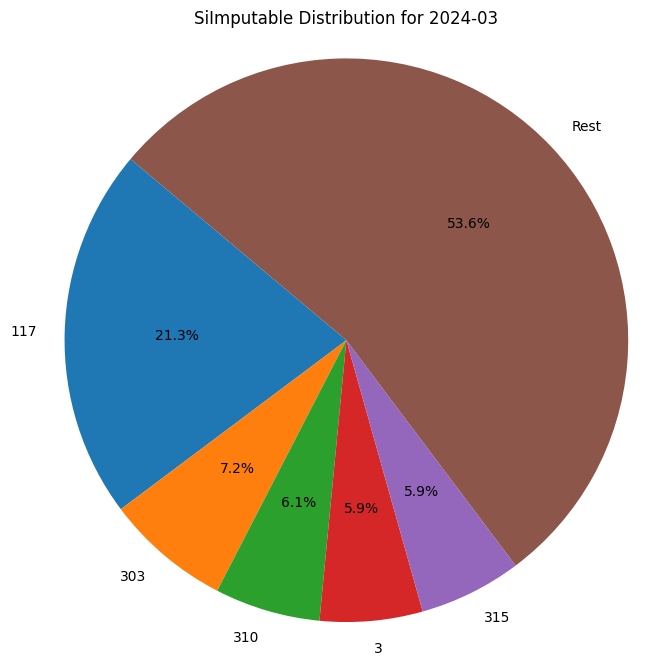

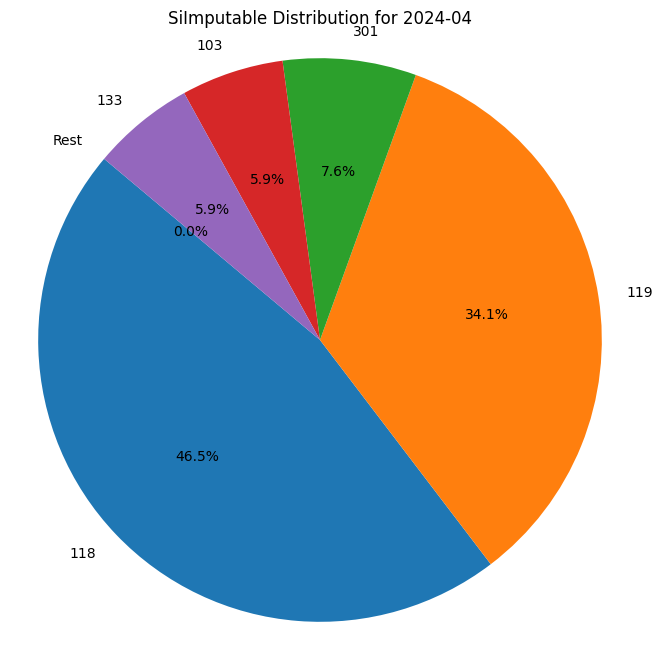

In [ ]:
# Filtrar los 5 principales equipmentId para cada 'Año-Mes'
top_5_per_month = filtered_df.groupby(['Año-Mes', 'equipmentId']).agg(SiImputable_sum=('SiImputable', 'sum')).reset_index()
top_5_per_month = top_5_per_month.groupby('Año-Mes').apply(lambda x: x.nlargest(5, 'SiImputable_sum')).reset_index(drop=True)

# Crear una lista de períodos únicos
unique_periods = filtered_df['Año-Mes'].unique()

# Crear gráficos de torta
for period in unique_periods:
    # Filtrar los datos para el periodo actual
    period_data = filtered_df[filtered_df['Año-Mes'] == period]
    period_top_5 = top_5_per_month[top_5_per_month['Año-Mes'] == period]
    
    # Calcular el total de SiImputable para el resto de los equipmentId
    top_5_ids = period_top_5['equipmentId'].unique()
    rest_sum = period_data[~period_data['equipmentId'].isin(top_5_ids)]['SiImputable'].sum()
    
    # Preparar los datos para el gráfico de torta
    labels = period_top_5['equipmentId'].astype(str).tolist() + ['Rest']
    sizes = period_top_5['SiImputable_sum'].tolist() + [rest_sum]
    
    # Crear el gráfico de torta
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'SiImputable Distribution for {period}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Mostrar el gráfico
    plt.show()


# PROCESOS IA 

## Criterios de revisión

### Armamos Query para tomar los valores históricos de la tasa de conversión en la IA por equipo

In [39]:
query = """SELECT 
    v.equipmentId,
    (COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 THEN v.videoId ELSE NULL END) / COUNT(DISTINCT CASE WHEN v.externalProvider != 0 THEN v.videoId ELSE NULL END))*100 as Tasa_IA
FROM
    Videos v    
WHERE v.recordedAt <= DATE_SUB(CURDATE(), INTERVAL 30 DAY)
    AND NOT (v.externalProvider = 0 AND v.deleted = 1) and v.processedAt is not null
    and v.externalProvider in (1,2)
GROUP BY v.equipmentId;"""

In [40]:
# Establecer la conexión a la base de datos
conn = mysql.connector.connect(
    host='10.0.50.104', 
    port=3306,     
    user='lroldan',      
    password='13579!!', 
    database='tng' 
)

cursor = conn.cursor()
# Ejecuta la consulta
cursor.execute(query)

# Obtén todos los resultados de la consulta
resultados = cursor.fetchall()

# Obtén los nombres de las columnas
columnas = [col[0] for col in cursor.description]

# Convierte los resultados a un DataFrame
df_IA = pd.DataFrame(resultados, columns=columnas)

# Cierra el cursor y la conexión a MySQL
cursor.close()
conn.close()
print("Conexión a MySQL cerrada")

Conexión a MySQL cerrada


In [41]:
df_IA

,equipmentId,Tasa_IA
0,1,13.4720
1,2,5.5355
2,3,9.6124
3,4,19.2944
4,5,46.6721
...,...,...
71,542,10.9119
72,543,8.1178
73,544,17.9199
74,545,10.1355


C:\Users\leabr\AppData\Local\Temp\ipykernel_14592\2514972828.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tasa_IA', y='equipmentId', data=top_10_mejores.sort_values('Tasa_IA', ascending=False), palette='viridis')


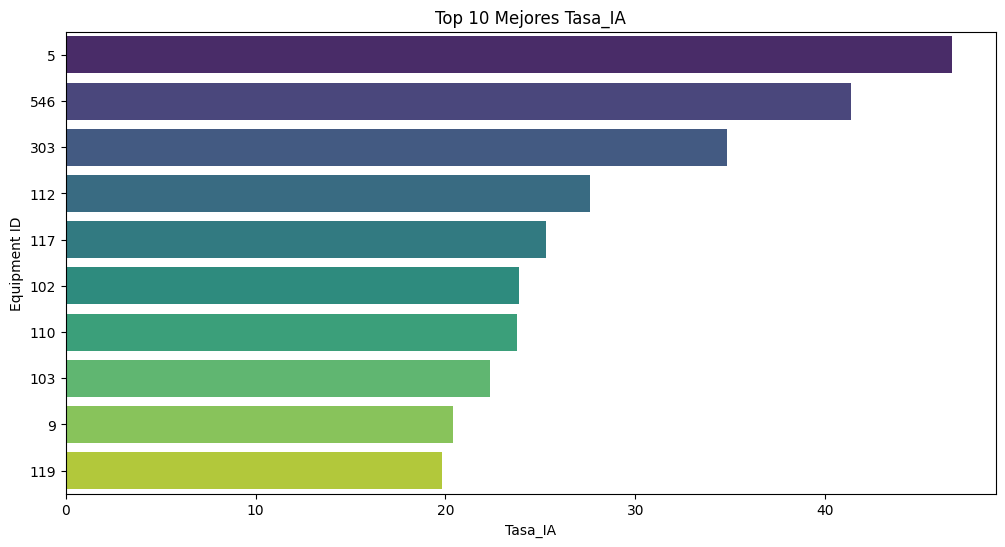

C:\Users\leabr\AppData\Local\Temp\ipykernel_14592\2514972828.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tasa_IA', y='equipmentId', data=top_10_peores.sort_values('Tasa_IA', ascending=True), palette='magma')


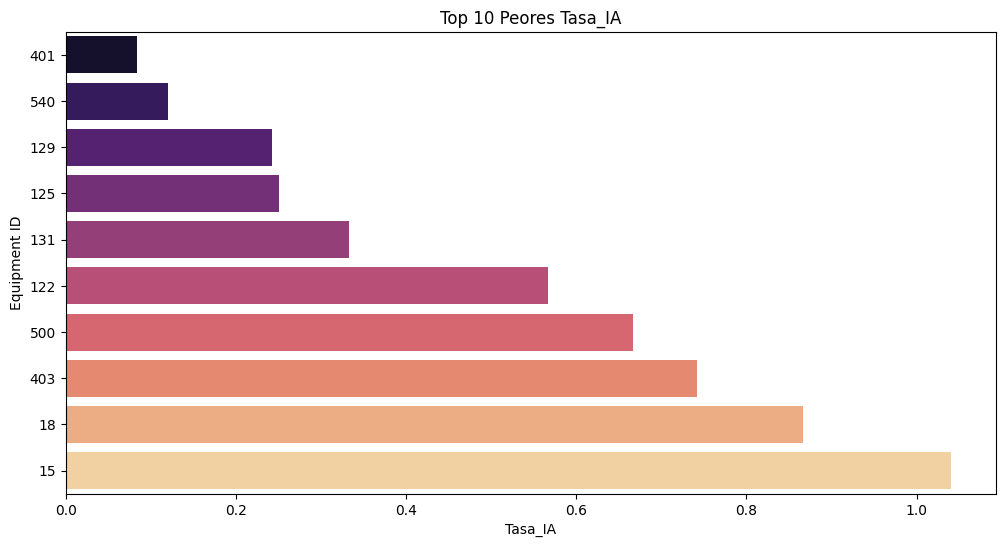

In [42]:
# Convertir la columna 'Tasa_IA' a tipo numérico
df_IA['Tasa_IA'] = pd.to_numeric(df_IA['Tasa_IA'])

# Seleccionar los top 10 mejores y peores valores de 'Tasa_IA'
top_10_mejores = df_IA.nlargest(10, 'Tasa_IA')
top_10_peores = df_IA.nsmallest(10, 'Tasa_IA')

# Convertir 'equipmentId' a tipo string para la visualización
top_10_mejores['equipmentId'] = top_10_mejores['equipmentId'].astype(str)
top_10_peores['equipmentId'] = top_10_peores['equipmentId'].astype(str)

# Graficar los top 10 mejores valores de 'Tasa_IA'
plt.figure(figsize=(12, 6))
sns.barplot(x='Tasa_IA', y='equipmentId', data=top_10_mejores.sort_values('Tasa_IA', ascending=False), palette='viridis')
plt.title('Top 10 Mejores Tasa_IA')
plt.xlabel('Tasa_IA')
plt.ylabel('Equipment ID')
plt.show()

# Graficar los top 10 peores valores de 'Tasa_IA'
plt.figure(figsize=(12, 6))
sns.barplot(x='Tasa_IA', y='equipmentId', data=top_10_peores.sort_values('Tasa_IA', ascending=True), palette='magma')
plt.title('Top 10 Peores Tasa_IA')
plt.xlabel('Tasa_IA')
plt.ylabel('Equipment ID')
plt.show()

In [43]:
query = """SELECT 
    YEAR(v.recordedAt) as Año,
    MONTH(v.recordedAt) as Mes,
    v.externalProvider as ID_IA,
    v.equipmentId, v.processedAt, 
    COUNT(DISTINCT v.videoId) as Registados, 
    COUNT(DISTINCT CASE WHEN v.externalProvider = 0 THEN v.videoId ELSE NULL END) as NoIA,
    COUNT(DISTINCT CASE WHEN v.externalProvider != 0 THEN v.videoId ELSE NULL END) as SiIA, 
    COUNT(DISTINCT CASE WHEN v.externalProvider != 0 and v.allegedInfraction = 0 THEN v.videoId ELSE NULL END) as NoAprIA, 
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 THEN v.videoId ELSE NULL END) as SiAprIA,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NULL THEN v.videoId ELSE NULL END) as NoEditor,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NOT NULL THEN v.videoId ELSE NULL END) as SiEditor,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NOT NULL AND v.approved = 0 THEN v.videoId ELSE NULL END) as NoAprEditor,
    COUNT(DISTINCT CASE WHEN v.allegedInfraction = 1 AND v.watchedBy IS NOT NULL AND v.approved = 1 THEN v.videoId ELSE NULL END) as SiAprEditor
FROM
    Videos v
LEFT JOIN
    Infractions i ON v.videoId = i.videoId
left join Transfers t on i.transferId=t.transferId    
WHERE v.recordedAt >= DATE_SUB(CURDATE(), INTERVAL 30 DAY)
    AND NOT (v.externalProvider = 0 AND v.deleted = 1) and v.processedAt is not null
GROUP BY Año, Mes, ID_IA, equipmentId, v.transferedToEPAt;"""

In [44]:
# Establecer la conexión a la base de datos
conn = mysql.connector.connect(
    host='10.0.50.104', 
    port=3306,     
    user='lroldan',      
    password='13579!!', 
    database='tng' 
)

cursor = conn.cursor()
# Ejecuta la consulta
cursor.execute(query)

# Obtén todos los resultados de la consulta
resultados = cursor.fetchall()

# Obtén los nombres de las columnas
columnas = [col[0] for col in cursor.description]

# Convierte los resultados a un DataFrame
df_IA_Actual = pd.DataFrame(resultados, columns=columnas)

# Cierra el cursor y la conexión a MySQL
cursor.close()
conn.close()
print("Conexión a MySQL cerrada")

Conexión a MySQL cerrada


In [46]:
df_IA_Actual

,Año,Mes,ID_IA,equipmentId,processedAt,Registados,NoIA,SiIA,NoAprIA,SiAprIA,NoEditor,SiEditor,NoAprEditor,SiAprEditor
0,2024,4,1,2,2024-05-26 17:02:06,1593,0,1593,1513,80,80,0,0,0
1,2024,4,1,5,2024-05-24 03:54:59,905,0,905,537,368,0,368,110,258
2,2024,4,1,6,2024-05-27 01:25:47,784,0,784,724,60,60,0,0,0
3,2024,4,1,15,2024-05-23 13:29:38,729,0,729,722,7,0,7,0,7
4,2024,4,1,16,2024-05-26 19:43:02,1157,0,1157,1076,81,81,0,0,0
5,2024,4,1,16,2024-05-27 09:05:05,296,0,296,278,18,18,0,0,0
6,2024,4,1,17,2024-05-26 14:39:37,876,0,876,820,56,56,0,0,0
7,2024,4,1,18,2024-05-27 03:09:06,743,0,743,735,8,8,0,0,0
8,2024,4,1,119,2024-05-27 11:07:15,165,0,165,158,7,2,5,2,3
9,2024,4,1,305,2024-05-19 16:51:31,1527,0,1527,1446,81,0,81,9,72


In [47]:
df_IA_merge = pd.merge(df_IA_Actual, df_IA, on='equipmentId', how='left')

df_IA_merge['Tasa_IA_actual'] =  df_IA_merge['SiAprIA'] / df_IA_merge['SiIA'] * 100

df_IA_merge['Porcentaje_Tasas'] =  df_IA_merge['Tasa_IA_actual'] / df_IA_merge['Tasa_IA'] * 100

df_IA_merge

,Año,Mes,ID_IA,equipmentId,processedAt,Registados,NoIA,SiIA,NoAprIA,SiAprIA,NoEditor,SiEditor,NoAprEditor,SiAprEditor,Tasa_IA,Tasa_IA_actual,Porcentaje_Tasas
0,2024,4,1,2,2024-05-26 17:02:06,1593,0,1593,1513,80,80,0,0,0,5.5355,5.021971,90.722990
1,2024,4,1,5,2024-05-24 03:54:59,905,0,905,537,368,0,368,110,258,46.6721,40.662983,87.124821
2,2024,4,1,6,2024-05-27 01:25:47,784,0,784,724,60,60,0,0,0,11.3313,7.653061,67.539128
3,2024,4,1,15,2024-05-23 13:29:38,729,0,729,722,7,0,7,0,7,1.0411,0.960219,92.231244
4,2024,4,1,16,2024-05-26 19:43:02,1157,0,1157,1076,81,81,0,0,0,5.8707,7.000864,119.250929
5,2024,4,1,16,2024-05-27 09:05:05,296,0,296,278,18,18,0,0,0,5.8707,6.081081,103.583577
6,2024,4,1,17,2024-05-26 14:39:37,876,0,876,820,56,56,0,0,0,10.3721,6.392694,61.633556
7,2024,4,1,18,2024-05-27 03:09:06,743,0,743,735,8,8,0,0,0,0.8664,1.076716,124.274702
8,2024,4,1,119,2024-05-27 11:07:15,165,0,165,158,7,2,5,2,3,19.8196,4.242424,21.405196
9,2024,4,1,305,2024-05-19 16:51:31,1527,0,1527,1446,81,0,81,9,72,5.1501,5.304519,102.998362
